In [11]:
# Imports
import investpy
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
US = 'united states'
START = '01/01/1992'
END = '01/01/2022'

In [13]:
# Get historical wheat price data from investpy
wheat_df = investpy.get_commodity_historical_data(commodity = 'US Wheat',
                                                  country = US,
                                                  from_date = START,
                                                  to_date = END)
wheat_df.drop(['Open','High','Low','Volume','Currency'], axis=1, inplace=True)
wheat_df.rename(columns = {'Close': 'Wheat'}, inplace=True)

In [14]:
# Get historical Dollar Index data from investpy
dx_df = investpy.get_index_historical_data(index = 'US Dollar Index',
                                           country = US,
                                           from_date = START,
                                           to_date = END)
dx_df.drop(['Open','High','Low','Volume','Currency'], axis=1, inplace=True)
dx_df.rename(columns = {'Close': 'Dollar'}, inplace=True)

In [15]:
# Get historical copper price data from investpy
copper_df = investpy.get_commodity_historical_data(commodity = 'Copper',
                                                   country = US,
                                                   from_date = START,
                                                   to_date = END)
copper_df.drop(['Open','High','Low','Volume','Currency'], axis=1, inplace=True)
copper_df.rename(columns = {'Close': 'Copper'}, inplace=True)

In [16]:
def convert_date_urea(date):
    return pd.to_datetime(date[-4:] + date[:4].strip(), format='%Y%b')

# Import urea (nitrogen fertilizer) price data
urea_df = pd.read_html("https://www.indexmundi.com/commodities/?commodity=urea&months=360")[1].drop(columns='Change', axis=0)
urea_df.Month = urea_df.Month.apply(convert_date_urea)
urea_df.set_index('Month', inplace=True)
urea_df.rename(columns = {'Price': 'Urea'}, inplace=True)

In [17]:
def convert_date_drought(date):
    date = str(date)
    return pd.to_datetime(date[:5] + date[5:], format='%Y%m')

# Import Palmer Drought Severity Index data for the Great Plains region
drought_df = pd.read_csv('./data/pdsi1992-2022.csv')
drought_df.Date = drought_df.Date.apply(convert_date_drought)
drought_df.set_index('Date', inplace=True)
drought_df.drop(columns='Anomaly', axis=0, inplace=True)
drought_df.rename(columns = {'Value': 'Drought'}, inplace=True)

In [18]:
# Combine data frames
combined_df = pd.concat([dx_df,copper_df,urea_df,drought_df,wheat_df], axis=1, join='outer')
# Seperate out month and year from index
combined_df['Month'] = combined_df.index.month
combined_df['Year'] = combined_df.index.year
# Fill nulls in Urea and Drought with monthly value
combined_df = combined_df.groupby(['Year','Month']).mean().dropna()
combined_df

Dollar    Copper    Urea  Drought       Wheat
Year Month                                                  
1992 7      82.406087  1.136500  120.00     2.92  337.284091
     8      80.834286  1.123000  120.00     3.78  312.386364
     9      81.725909  1.073952  120.00     3.25  333.238095
     10     84.954545  1.001045  116.88     2.53  349.556818
     11     89.924286  0.961263  107.50     3.35  369.369048
...               ...       ...     ...      ...         ...
2021 8      92.799545  4.275977  446.88    -2.32  725.738636
     9      92.952727  4.251239  418.75    -3.06  704.693182
     10     93.945238  4.384524  695.00    -2.37  745.547619
     11     95.341364  4.346636  900.50    -3.00  806.619048
     12     96.208182  4.323957  890.00    -3.28  788.817391

[354 rows x 5 columns]

In [19]:
# Create correlation matrix
correlations_df = combined_df.corr()
correlations_df

,Dollar,Copper,Urea,Drought,Wheat
Dollar,1.000000,-0.583588,-0.542880,-0.008699,-0.652276
Copper,-0.583588,1.000000,0.799196,-0.300945,0.822573
Urea,-0.542880,0.799196,1.000000,-0.292428,0.781340
Drought,-0.008699,-0.300945,-0.292428,1.000000,-0.215552
Wheat,-0.652276,0.822573,0.781340,-0.215552,1.000000


## Visualizations

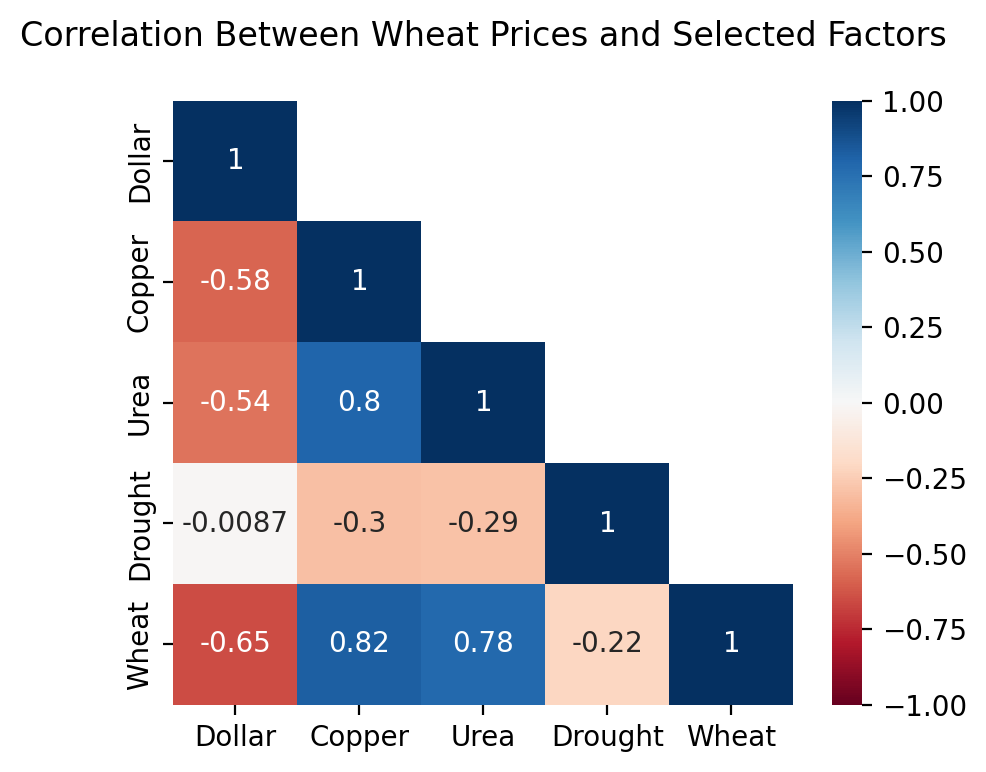

In [75]:
# Create mask for correlation heatmap
mask = np.triu(np.ones_like(correlations_df))
np.fill_diagonal(mask, 0)

# Show correlation heatmap
fig, ax = plt.subplots(figsize=(5, 4),dpi=200)
sns.heatmap(correlations_df,cmap='RdBu',annot=True, vmin=-1, vmax=1, ax=ax, mask=mask)
ax.set_title('Correlation Between Wheat Prices and Selected Factors\n')
plt.show()